# **Import Essential Libraries**

In [ ]:
# Import Data Science Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from PIL import Image

# Tensorflow Libraries
from tensorflow import keras
from tensorflow.keras import layers,models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import Callback, EarlyStopping,ModelCheckpoint
from tensorflow.keras.optimizers import Adam, SGD, Adadelta
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import Model
from tensorflow.keras.layers import Rescaling
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D

# System libraries
from pathlib import Path
import os.path
import os
import shutil

# Metrics
from sklearn.metrics import classification_report, confusion_matrix
import itertools

# **Base Model for Mobilenetv2**

In [ ]:
base_model = MobileNetV2(weights='imagenet',input_shape =(224,224,3), include_top=False)
for layer in base_model.layers:
    layer.trainable=False

In [ ]:
x=base_model.output
x=GlobalAveragePooling2D()(x)
x=Dense(128)(x)
X=Dropout(0.25)(x)
x=Dense(128)(x)
preds=Dense(23 ,activation='softmax')(x) #final layer with softmax activation for N classes

model=Model(inputs=base_model.input,outputs=preds) #specify the inputs and outputs
model.summary()

# **Helper Function**

In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

# Import series of helper functions for our notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir, pred_and_plot

# **Mounting to Google**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# Walk through each directory
dataset = "/content/drive/MyDrive/Colab Notebooks/Kaganga HW"
walk_through_dir(dataset)

# **Separate Dataset ino Training, Testing and Validation**

In [ ]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Fungsi untuk membuat folder
def create_dir(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)

# Path dataset asal
dataset = "/content/drive/MyDrive/Colab Notebooks/Kaganga HW"

# Path folder tujuan
output_base = "/content/drive/MyDrive/Colab Notebooks/Kaganga HW Split"
train_dir = os.path.join(output_base, "train")
val_dir = os.path.join(output_base, "val")
test_dir = os.path.join(output_base, "test")

# Membuat direktori output
create_dir(train_dir)
create_dir(val_dir)
create_dir(test_dir)

# Walk through each directory untuk mendapatkan semua file gambar
image_files = []
labels = []

for root, _, files in os.walk(dataset):
    for file in files:
        if file.endswith(('.jpg')):  # Pastikan format gambar sesuai
            image_files.append(os.path.join(root, file))
            labels.append(os.path.basename(root))  # Label adalah nama folder

# Pisahkan data menjadi train, test, dan validasi
train_files, test_files, train_labels, test_labels = train_test_split(
    image_files, labels, test_size=0.2, shuffle=True, random_state=42
)

train_files, val_files, train_labels, val_labels = train_test_split(
    train_files, train_labels, test_size=0.2, shuffle=True, random_state=42
)

# Fungsi untuk memindahkan file ke direktori tujuan
def move_files(files, labels, dest_dir):
    for file_path, label in zip(files, labels):
        label_dir = os.path.join(dest_dir, label)
        create_dir(label_dir)
        shutil.copy(file_path, os.path.join(label_dir, os.path.basename(file_path)))

# Pindahkan file ke folder masing-masing
move_files(train_files, train_labels, train_dir)
move_files(val_files, val_labels, val_dir)
move_files(test_files, test_labels, test_dir)

print("Dataset berhasil dipisahkan:")
print(f"Training: {len(train_files)} file")
print(f"Validation: {len(val_files)} file")
print(f"Testing: {len(test_files)} file")

# **Change Dataset into Dataframe**

In [ ]:
# Fungsi untuk membuat dataframe dari folder gambar
def create_dataframe(image_dir):
    filepaths = list(image_dir.glob(r'**/*.JPG')) + list(image_dir.glob(r'**/*.jpg')) + list(image_dir.glob(r'**/*.png'))
    labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))
    filepaths = pd.Series(filepaths, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')
    return pd.concat([filepaths, labels], axis=1)

# Path ke folder yang telah dibuat sebelumnya
train_dir = Path("/content/drive/MyDrive/Colab Notebooks/Kaganga HW Split/train")
val_dir = Path("/content/drive/MyDrive/Colab Notebooks/Kaganga HW Split/val")
test_dir = Path("/content/drive/MyDrive/Colab Notebooks/Kaganga HW Split/test")

# Buat dataframe untuk training, validation, dan testing
train_df = create_dataframe(train_dir)
val_df = create_dataframe(val_dir)
test_df = create_dataframe(test_dir)

# Tampilkan hasil
print("Training DataFrame:")
print(train_df.head())

print("\nValidation DataFrame:")
print(val_df.head())

print("\nTesting DataFrame:")
print(test_df.head())

# **Image data generator**

In [ ]:
train_datagen = ImageDataGenerator( # create an instance of ImageDataGenerator
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split=0.2,
    zoom_range=0.2,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
)

test_datagen = ImageDataGenerator( # create an instance of ImageDataGenerator
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

train_dataset = train_datagen.flow_from_dataframe( # call flow_from_dataframe on the instance
        dataframe=train_df,
        x_col='Filepath',
        y_col='Label',
        target_size=(224, 224),
        batch_size=128,
        class_mode="categorical",
        shuffle=True)

test_images = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=128,
    shuffle=False
)


validation_dataset = test_datagen.flow_from_dataframe( # call flow_from_dataframe on the instance
                                                 dataframe=val_df,
                                                 x_col='Filepath',
                                                 y_col='Label',
                                                 shuffle=True,
                                                 target_size=(224, 224),
                                                 class_mode='categorical')

# **Training the model**

In [ ]:
checkpoint = tf.keras.callbacks.ModelCheckpoint('/content/drive/My Drive/data/MobileNetV222_save.keras', verbose=1, save_best_only=True)
callbacks = [tf.keras.callbacks.EarlyStopping(patience=3, monitor='val_loss'),
             tf.keras.callbacks.TensorBoard(log_dir='/content/drive/My Drive/MoobileNetV2_log'),
             checkpoint]

model.compile(loss= tf.keras.losses.CategoricalCrossentropy(),
              optimizer=Adam(learning_rate=0.001),
              metrics=['accuracy'])

history = model.fit(
      train_dataset,
      callbacks=callbacks,
      validation_data=validation_dataset,
      epochs=10,
      verbose=1)

In [ ]:
results = model.evaluate(test_images, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

# **Visualization**

In [ ]:
plot_loss_curves(history)

In [ ]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_dataset.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Display the result
print(f'The first 5 predictions: {pred[:5]}')

15/15 ━━━━━━━━━━━━━━━━━━━━ 15s 803ms/step
The first 5 predictions: ['Nda', 'Ca', 'Nja', 'Ga', 'Ga']


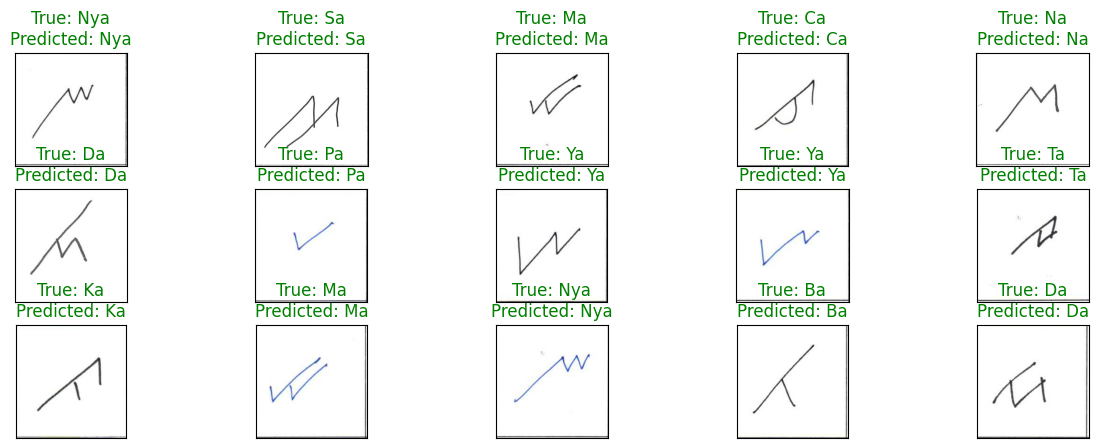

<Figure size 640x480 with 0 Axes>

In [ ]:
# Display 25 random pictures from the dataset with their labels
random_index = np.random.randint(0, len(test_df) - 1, 50)
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15, 5),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    image = Image.open(test_df.Filepath.iloc[random_index[i]])
    ax.imshow(image)
    if test_df.Label.iloc[random_index[i]] == pred[random_index[i]]:
      color = "green"
    else:
      color = "red"
    ax.set_title(f"True: {test_df.Label.iloc[random_index[i]]}\nPredicted: {pred[random_index[i]]}", color=color)
plt.show()
plt.tight_layout()

# **Classification Report**

In [ ]:
y_test = list(test_df.Label)
print(classification_report(y_test, pred))

# **Confusion Matrix**

In [ ]:
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(15, 7), text_size=10, norm=False, savefig=False):

  # Create the confustion matrix
    cm = confusion_matrix(y_true, y_pred)
    cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
    n_classes = cm.shape[0]

    # Plot the figure and make it pretty
    fig, ax = plt.subplots(figsize=figsize)
    cax = ax.matshow(cm, cmap=plt.cm.Blues)
    fig.colorbar(cax)

    # Are there a list of classes?
    if classes:
        labels = classes
    else:
        labels = np.arange(cm.shape[0])

    # Label the axes
    ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes),
         yticks=np.arange(n_classes),
         xticklabels=labels,
         yticklabels=labels)

    # Make x-axis labels appear on bottom
    ax.xaxis.set_label_position("bottom")
    ax.xaxis.tick_bottom()
    plt.xticks(rotation=90, fontsize=text_size)
    plt.yticks(fontsize=text_size)

    # Set the threshold for different colors
    threshold = (cm.max() + cm.min()) / 2.

    # Plot the text on each cell
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if norm:
            plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
                horizontalalignment="center",
                color="white" if cm[i, j] > threshold else "black",
                size=text_size)
        else:
            plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
    if savefig:
        fig.savefig("confusion_matrix.png")

In [ ]:
make_confusion_matrix(y_test, pred, list(labels.values()))

# **Save model**


In [ ]:
model.save('/content/drive/MyDrive/Colab Notebooks/KaGaNga_Model_HW.h5')